# Setup Environment

In [1]:
# Install Packages
print('Installing packages...')
!pip install -q kaggle
!pip install -q split-folders

# Import Libraries
print('Importing libraries...')
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import json


from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd

from tensorflow.keras.layers import Dropout , BatchNormalization
from tensorflow.keras import regularizers

import split_folders

import tensorflow as tf

print(f'\nTensorFlow Version: {tf.__version__}')

Installing packages...
Importing libraries...

TensorFlow Version: 2.2.0


In [2]:
# Setup Kaggle for Google Colab Environment
print('Setting up Kaggle for Google Colab...')
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# api_token = {'username':'...','key':'...'}


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

Setting up Kaggle for Google Colab...


In [3]:
# Download and unzip Kaggle Dataset
print('Downloading Kaggle Dataset...')
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p /content
!unzip -qq \*.zip

print(f'\nSetup complete using TensorFlow Version: {tf.__version__}!')

 99% 668M/675M [00:12<00:00, 74.5MB/s]
100% 675M/675M [00:12<00:00, 57.7MB/s]

Setup complete using TensorFlow Version: 2.2.0!


In [4]:
print('Splitting folder into train, validation, and test folders... ')
# Remove duplicate cell_images nested within cell_images
!rm cell_images/cell_images/ -rf

split_folders.ratio('cell_images', output="dataset", seed=1337, ratio=(.8, .1, .1)) # default values

Splitting folder into train, validation, and test folders... 


Copying files: 27560 files [00:03, 7037.96 files/s]


# Functions

In [5]:
def get_image_generator(dir, param_dict):
    """Returns an instance of an ImageDataGenerator generated from the given directory

    Args:
      dir: directory path

    Returns:
      An image generator of the images from the specified directory
    """
    img_data_generator = ImageDataGenerator(rescale = 1./255)
    img_generator = img_data_generator.flow_from_directory(dir,
                                         target_size=(param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE']),
                                         batch_size=param_dict['BATCH_SIZE'],
                                         class_mode='binary')
    return img_generator

In [6]:
def plot_images(dir, param_dict):
    """Plots a sample of images

    Args:
      dir: training directory path
      param_dict: a dictionary of parameters

    """
    class_mapping = dict(zip(range(len(os.listdir(dir))), os.listdir(dir)))

    img_generator = get_image_generator(dir, param_dict)

    images, labels = img_generator.next()

    fig, ax = plt.subplots(4, 8, figsize=(20, 14)) 
    for i in range(32):
        ax[int(i/8),i%8].set_axis_off()
        ax[int(i/8),i%8].imshow(images[i])
        ax[int(i/8),i%8].set_title(class_mapping[labels[i]])

In [7]:
def get_model(wd, rate, param_dict):
    """ Builds and compiles a deep neural network

    Args:
      wd: weight decay
      rate: drop rate
      param_dict: a dictionary of parameters

    Returns:
      The compiled neural network model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (param_dict['IMAGE_SIZE'], param_dict['IMAGE_SIZE'], 3)), 
        tf.keras.layers.MaxPooling2D(4,4),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(4,4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        BatchNormalization(momentum=0.95,
                           epsilon=0.005,
                           axis = -1,
                           beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                           gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dropout(rate),
        tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        BatchNormalization(momentum=0.95,
                           epsilon=0.005,
                           axis = -1,
                           beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                           gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dropout(rate),
        tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        BatchNormalization(momentum=0.95,
                           epsilon=0.005,
                           axis = -1,
                           beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                           gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dropout(rate),
        tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        BatchNormalization(momentum=0.95,
                           epsilon=0.005,
                           axis = -1,
                           beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                           gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dropout(rate),
        tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        BatchNormalization(momentum=0.95,
                           epsilon=0.005,
                           axis = -1,
                           beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                           gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dropout(rate),
        tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        BatchNormalization(momentum=0.95,
                           epsilon=0.005,
                           axis = -1,
                           beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                           gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dropout(rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    metrics = ['accuracy',
               'AUC',
               'Precision',
               'Recall',
               'TruePositives',
               'TrueNegatives',
               'FalsePositives',
               'FalseNegatives']

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

In [8]:
def get_test_results(model, test):
    """ Evaluates the model on the test data and returns the results

    Args:
      model: neural network model
      test: test data

    Returns:
      The a dictionary of the results after evaluating the model
    """
    scores = model.evaluate(test, verbose=0)
    metrics = ['loss',
           'accuracy',
            'AUC',
            'Precision',
            'Recall',
            'TruePositives',
            'TrueNegatives',
            'FalsePositives',
            'FalseNegatives',
            'PrecisionAtRecall']

    metric_scores = dict(zip(metrics, scores))

    metric_scores['F1'] = 2 * metric_scores['Precision'] * metric_scores['Recall'] / (metric_scores['Precision'] + metric_scores['Recall'])

    return metric_scores

In [9]:
def plot_history(history):
    """ Plots the loss, accuracy, and AUC ROC metrics of the train and validation

    Args:
      history: the history of metrics for each epoch

    Returns:
      A dataframe of the history
    """
    df = pd.DataFrame(history.history)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

    df.plot(ax=ax[0,], y=['loss', 'val_loss'])
    ax[0].set_title('Loss vs Epoch')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')


    df.plot(ax=ax[1], y=['accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy vs Epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
 

    df.plot(ax=ax[2], y=['auc', 'val_auc'])
    ax[2].set_title('AUC ROC vs Epoch')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('ROC AUC')   
    plt.show()

    return pd.DataFrame(history.history)

# Callbacks

In [10]:
# Tensorflow checkpoint object which monitors the validation accuracy
checkpoint_path = 'model_checkpoint/checkpoint' 
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_freq='epoch',
                             monitor='val_auc',
                             save_best_only=True, 
                             verbose=0)

# Examine Data

In [11]:
# Folder directories
train_dir = 'dataset/train/'
val_dir = 'dataset/val/'
test_dir = 'dataset/test/'

# Parameters
parameters = {'IMAGE_SIZE': 150,
              'BATCH_SIZE': 32}

class_count = len(os.listdir(train_dir))
print(f'Number of classes: {class_count}')

Number of classes: 2


Found 22046 images belonging to 2 classes.


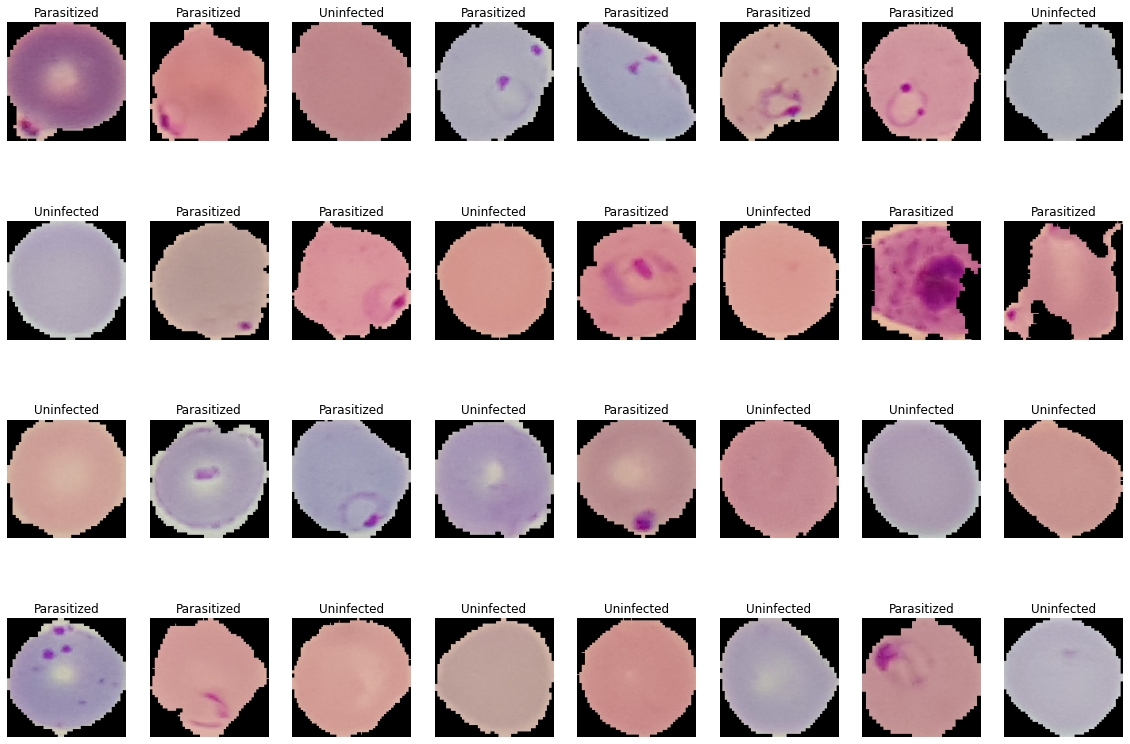

In [13]:
plot_images(train_dir, parameters)

In [14]:
train_generator = get_image_generator(train_dir, parameters)
val_generator = get_image_generator(val_dir, parameters)
test_generator = get_image_generator(test_dir, parameters)

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


# Modeling

In [15]:
model = get_model(1e-5, 0.3, parameters)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1

In [16]:
history = model.fit(train_generator,
                    epochs = 100,
                    steps_per_epoch=train_generator.samples//parameters['BATCH_SIZE'],
                    validation_data=val_generator,
                    validation_steps=val_generator.samples//parameters['BATCH_SIZE'],
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3), checkpoint]
                    )

Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
688/688 [==============================] - 39s 56ms/step - loss: 0.6790 - accuracy: 0.6190 - auc: 0.6701 - precision: 0.6241 - recall: 0.5981 - true_positives: 6583.0000 - true_negatives: 7043.0000 - false_positives: 3965.0000 - false_negatives: 4423.0000 - val_loss: 1.5159 - val_accuracy: 0.6028 - val_auc: 0.8719 - val_precision: 0.5583 - val_recall: 0.9818 - val_true_positives: 1350.0000 - val_true_negatives: 309.0000 - val_false_positives: 1068.0000 - val_false_negatives: 25.0000
Epoch 2/100
688/688 [==============================] - 34s 49ms/step - loss: 0.2787 - accuracy: 0.9066 - auc: 0.9528 - precision: 0.8966 - recall: 0.9193 - true_positives: 10124.0000 - true_negatives: 9833.0000 - false_positives: 1168.0000 - false_negatives: 889.0000 - val_loss: 0.1953 - val_accuracy: 0.9357 - val_auc: 0.9786 - val_precision: 0.9021 - val_recall: 0.9775 - val_true_positives: 1346.0000 - val_true_neg

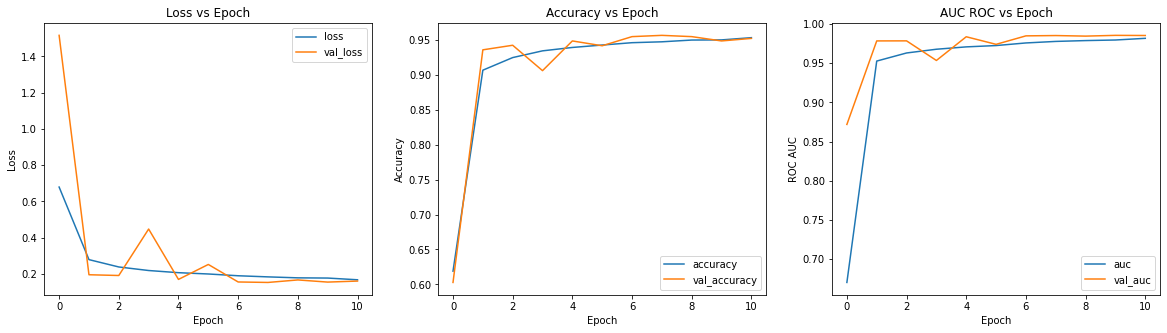

,loss,accuracy,auc,precision,recall,true_positives,true_negatives,false_positives,false_negatives,val_loss,val_accuracy,val_auc,val_precision,val_recall,val_true_positives,val_true_negatives,val_false_positives,val_false_negatives
0,0.679046,0.618970,0.670121,0.624099,0.598128,6583.0,7043.0,3965.0,4423.0,1.515932,0.602834,0.871895,0.558313,0.981818,1350.0,309.0,1068.0,25.0
1,0.278669,0.906559,0.952814,0.896564,0.919277,10124.0,9833.0,1168.0,889.0,0.195278,0.935683,0.978552,0.902145,0.977487,1346.0,1229.0,146.0,31.0
2,0.238165,0.924593,0.963146,0.911154,0.940952,10358.0,9996.0,1010.0,650.0,0.191113,0.942224,0.978620,0.919421,0.969499,1335.0,1258.0,117.0,42.0
3,0.218609,0.934224,0.967923,0.922907,0.947565,10427.0,10139.0,871.0,577.0,0.447389,0.905887,0.953588,0.848504,0.988381,1361.0,1132.0,243.0,16.0
4,0.206637,0.939084,0.970937,0.927081,0.953112,10489.0,10184.0,825.0,516.0,0.169514,0.948401,0.983859,0.918699,0.984035,1356.0,1254.0,120.0,22.0
5,0.199458,0.942537,0.972623,0.929453,0.957747,10540.0,10209.0,800.0,465.0,0.252004,0.941497,0.974178,0.902584,0.989826,1362.0,1229.0,147.0,14.0
6,0.189677,0.945898,0.975956,0.935862,0.957379,10535.0,10288.0,722.0,469.0,0.155391,0.954578,0.985006,0.935933,0.976035,1344.0,1283.0,92.0,33.0
7,0.183504,0.947170,0.977907,0.937494,0.958197,10544.0,10307.0,703.0,460.0,0.152787,0.956395,0.985398,0.941673,0.973130,1340.0,1292.0,83.0,37.0
8,0.178163,0.949668,0.978973,0.941481,0.958932,10554.0,10352.0,656.0,452.0,0.166608,0.954578,0.984678,0.932227,0.980364,1348.0,1279.0,98.0,27.0
9,0.176998,0.949896,0.979714,0.941538,0.959408,10565.0,10346.0,656.0,447.0,0.154774,0.948401,0.985651,0.946454,0.950581,1308.0,1302.0,74.0,68.0


In [17]:
plot_history(history)

# Evaluate on Test Set

In [18]:
pd.Series(get_test_results(model, test_generator))

loss                 0.161886
accuracy             0.953193
AUC                  0.984429
Precision            0.933982
Recall               0.975327
TruePositives     1344.000000
TrueNegatives     1283.000000
FalsePositives      95.000000
FalseNegatives      34.000000
F1                   0.954207
dtype: float64